### Compare structural measures across datasets

#### Datasets
- NIMHANS
- QPN
- PPMI

#### Measures
- Cortical thickness (FS)
- Regional volumes (FS)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting


In [1]:
projects_dir = f"/home/nikhil/projects/Parkinsons/neuro_arch/analysis" 

IDP_dir = f"{projects_dir}/IDP"
figs_dir = f"{projects_dir}/figures/ADPD/poster/"

qpn_release = "Jan_2024"

nimhans_serb_agg_data_dir = f"{IDP_dir}/nimhans_serb/agg_dfs/"
nimhans_metal_agg_data_dir = f"{IDP_dir}/nimhans_metal/agg_dfs/"
qpn_agg_data_dir = f"{IDP_dir}/qpn/{qpn_release}/agg_dfs/"
ppmi_agg_data_dir = f"{IDP_dir}/ppmi/agg_dfs/"

CT_DKT_csv = "CT_DKT_df.csv"
bilateral_vol_csv = "bilateral_vol_ASEG_df.csv"
global_vol_csv = "global_vol_ASEG_df.csv"

demo_cols = ["participant_id","bids_id","age","sex","group","hemi","ds"]

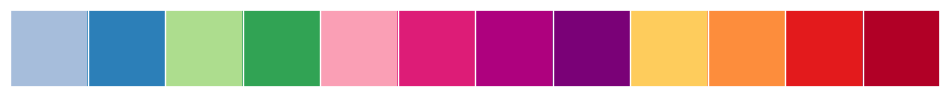

In [36]:
from enum import Enum
# class my_colors(Enum):
#     NIM_SERB_CONTROL = "#a6bddb"
#     NIM_SERB_PD = "#2c7fb8"
#     NIM_METAL_CONTROL = "#addd8e"
#     NIM_METAL_PD = "#31a354"

#     QPN_CONTROL = "#fa9fb5"
#     QPN_PD = "#dd1c77"
#     QPN_older_CONTROL = "#ae017e"
#     QPN_older_PD = "#7a0177"
#     PPMI_CONTROL = "#fecc5c"
#     # PPMI_PRODROMAL = "#fecc5c"
#     PPMI_PD = "#fd8d3c"
#     PPMI_older_CONTROL = "#e31a1c"
#     PPMI_older_PD = "#b10026"

# Poster colors
class my_colors(Enum):
    NIM_SERB_CONTROL =  "#bdd7e7"
    NIM_SERB_PD =       "#6baed6"
    NIM_METAL_CONTROL = "#3182bd"
    NIM_METAL_PD =      "#08519c"

    QPN_CONTROL =       "#cbc9e2"
    QPN_PD =            "#9e9ac8"
    QPN_older_CONTROL = "#756bb1"
    QPN_older_PD =      "#54278f"

    PPMI_CONTROL =      "#fcae91"
    PPMI_PD =           "#fb6a4a"
    PPMI_older_CONTROL= "#de2d26"
    PPMI_older_PD =     "#a50f15"
    



color_list = [  my_colors.NIM_SERB_CONTROL.value, my_colors.NIM_SERB_PD.value,
                my_colors.NIM_METAL_CONTROL.value, my_colors.NIM_METAL_PD.value,
                my_colors.QPN_CONTROL.value, my_colors.QPN_PD.value, 
                my_colors.QPN_older_CONTROL.value, my_colors.QPN_older_PD.value,
                my_colors.PPMI_CONTROL.value, my_colors.PPMI_PD.value,
                my_colors.PPMI_older_CONTROL.value, my_colors.PPMI_older_PD.value              
              ]

palette = sns.color_palette(palette=color_list) #sns.husl_palette()

hue_order = ["NIMHANS-1-control", "NIMHANS-1-PD", "NIMHANS-2-control", "NIMHANS-2-PD", 
             "QPN-young-control", "QPN-young-PD", "QPN-older-control", "QPN-older-PD",
             "PPMI-young-control",  "PPMI-young-PD","PPMI-older-control",  "PPMI-older-PD"] #"PPMI-prodromal",

sns.palplot(palette)

### Read data

In [4]:
match_age = True
age_thresh = 65

In [22]:
# NIMHANS (SERB + METAL)
nimhans_serb_CT_DKT_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_CT_DKT_df["ds"] = "NIMHANS-1"
n_nimhans_serb_participants = len(nimhans_serb_CT_DKT_df["participant_id"].unique())

nimhans_metal_CT_DKT_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
nimhans_metal_CT_DKT_df["ds"] = "NIMHANS-2"
n_nimhans_metal_participants = len(nimhans_metal_CT_DKT_df["participant_id"].unique())

# QPN
qpn_CT_DKT_df = pd.read_csv(f"{qpn_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
qpn_CT_DKT_df["ds"] = "QPN"
n_qpn_participants = len(qpn_CT_DKT_df["participant_id"].unique())

# PPMI
ppmi_CT_DKT_df = pd.read_csv(f"{ppmi_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
ppmi_CT_DKT_df["ds"] = "PPMI"
ppmi_CT_DKT_df["participant_id"] = ppmi_CT_DKT_df["participant_id"].astype(str)
ppmi_CT_DKT_df["bids_id"] = "sub-" + ppmi_CT_DKT_df["participant_id"]

n_ppmi_participants = len(ppmi_CT_DKT_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}, n_qpn_participants (all):{n_qpn_participants}, n_ppmi_participants: {n_ppmi_participants}")

if match_age:
    print(f"Matching age < {age_thresh}")
    qpn_young_CT_DKT_df = qpn_CT_DKT_df[qpn_CT_DKT_df["age"] < age_thresh].copy()
    qpn_young_CT_DKT_df["ds"] = "QPN-young"

    qpn_older_CT_DKT_df = qpn_CT_DKT_df[qpn_CT_DKT_df["age"] >= age_thresh].copy()
    qpn_older_CT_DKT_df["ds"] = "QPN-older"

    ppmi_young_CT_DKT_df = ppmi_CT_DKT_df[ppmi_CT_DKT_df["age"] < age_thresh].copy()
    ppmi_young_CT_DKT_df["ds"] = "PPMI-young"

    ppmi_older_CT_DKT_df = ppmi_CT_DKT_df[ppmi_CT_DKT_df["age"] >= age_thresh].copy()
    ppmi_older_CT_DKT_df["ds"] = "PPMI-older"

    n_qpn_young_participants = len(qpn_young_CT_DKT_df["participant_id"].unique())
    n_qpn_older_participants = len(qpn_older_CT_DKT_df["participant_id"].unique())

    n_ppmi_young_participants = len(ppmi_young_CT_DKT_df["participant_id"].unique())
    n_ppmi_older_participants = len(ppmi_older_CT_DKT_df["participant_id"].unique())

    print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}")
    print(f"n_qpn_participants (young):{n_qpn_young_participants}, n_ppmi_participants (young): {n_ppmi_young_participants}")
    print(f"n_qpn_participants (older):{n_qpn_older_participants}, n_ppmi_participants: {n_ppmi_older_participants}")

# Concat
CT_DKT_df = pd.concat([nimhans_serb_CT_DKT_df, nimhans_metal_CT_DKT_df, 
                        qpn_young_CT_DKT_df, qpn_older_CT_DKT_df,
                        ppmi_young_CT_DKT_df, ppmi_older_CT_DKT_df], axis=0) 


CT_DKT_df["ds_group"] = CT_DKT_df["ds"] + "-" + CT_DKT_df["group"]
CT_DKT_df["ds_hemi"] = CT_DKT_df["ds"] + "\n" + CT_DKT_df["hemi"]
print(f"CT_DKT_df shape: {CT_DKT_df.shape}, n_total_participants: {len(CT_DKT_df['participant_id'].unique())}")


## tmp
# CT_DKT_df = CT_DKT_df.drop(columns=["participant_id"])

CT_DKT_df.head()

n_nimhans_participants: (86, 130), n_qpn_participants (all):287, n_ppmi_participants: 406
Matching age < 65
n_nimhans_participants: (86, 130)
n_qpn_participants (young):57, n_ppmi_participants (young): 237
n_qpn_participants (older):73, n_ppmi_participants: 168
CT_DKT_df shape: (1502, 40), n_total_participants: 751


,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,insula,isthmuscingulate,lateraloccipital,...,transversetemporal,participant_id,bids_id,age,sex,group,hemi,ds,ds_group,ds_hemi
0,2.643,2.648,1.866,3.932,3.098,2.638,2.969,3.294,2.312,2.189,...,2.386,SERB088,sub-SERB088,54.0,M,PD,lh,NIMHANS-1,NIMHANS-1-PD,NIMHANS-1\nlh
1,3.230,2.844,1.941,3.825,2.900,2.479,3.003,3.427,2.308,2.365,...,1.971,SERB058,sub-SERB058,64.0,M,PD,lh,NIMHANS-1,NIMHANS-1-PD,NIMHANS-1\nlh
2,2.756,2.717,1.997,3.036,2.709,2.457,2.875,3.183,2.388,2.123,...,1.875,SERB049,sub-SERB049,62.0,M,PD,lh,NIMHANS-1,NIMHANS-1-PD,NIMHANS-1\nlh
3,2.974,2.603,1.819,3.802,2.701,2.399,2.947,3.205,2.468,2.364,...,2.250,SERB084,sub-SERB084,NaN,NaN,PD,lh,NIMHANS-1,NIMHANS-1-PD,NIMHANS-1\nlh
4,3.015,2.939,1.998,4.177,3.054,2.831,3.403,3.701,2.462,2.382,...,2.776,SERB063,sub-SERB063,56.0,M,PD,lh,NIMHANS-1,NIMHANS-1-PD,NIMHANS-1\nlh


### Subsample QPN to match age

In [23]:
CT_DKT_df.groupby(["ds","group"])["age"].describe()

count       mean        std   min    25%    50%     75%  \
ds         group                                                                
NIMHANS-1  PD         108.0  55.388889   7.165381  36.0  50.00  56.00  61.000   
           control     30.0  52.000000   5.907330  41.0  48.50  53.00  56.750   
NIMHANS-2  PD         118.0  53.644068  10.089790  24.0  46.00  55.00  61.000   
           control    128.0  50.015625  10.377887  20.0  42.75  50.00  57.250   
PPMI-older PD         204.0  70.843137   3.939806  65.0  68.00  70.00  73.000   
           control     58.0  70.413793   4.720372  65.0  66.00  70.00  73.000   
           prodromal   74.0  70.621622   4.648472  65.0  67.00  70.00  73.000   
PPMI-young PD         254.0  55.826772   6.225149  38.0  51.25  56.00  61.000   
           control    100.0  53.580000   8.492635  31.0  49.00  55.50  60.000   
           prodromal  120.0  57.650000   4.932571  42.0  54.00  58.50  61.250   
QPN-older  PD         104.0  72.123077   5.435111  65.0  68.00  71.30  75.925   
           control     42.0  71.361905   4.366891  65.1  68.20  70.90  73.100   
QPN-young  PD          82.0  56.624390   5.962052  40.8  53.00  57.60  61.100   
           control     32.0  55.837500   6.932195  43.4  49.15  57.85  61.725   

                       max  
ds         group            
NIMHANS-1  PD         67.0  
           control    60.0  
NIMHANS-2  PD         72.0  
           control    73.0  
PPMI-older PD         82.0  
           control    81.0  
           prodromal  84.0  
PPMI-young PD         64.0  
           control    64.0  
           prodromal  64.0  
QPN-older  PD         88.3  
           control    80.4  
QPN-young  PD         64.6  
           control    63.5

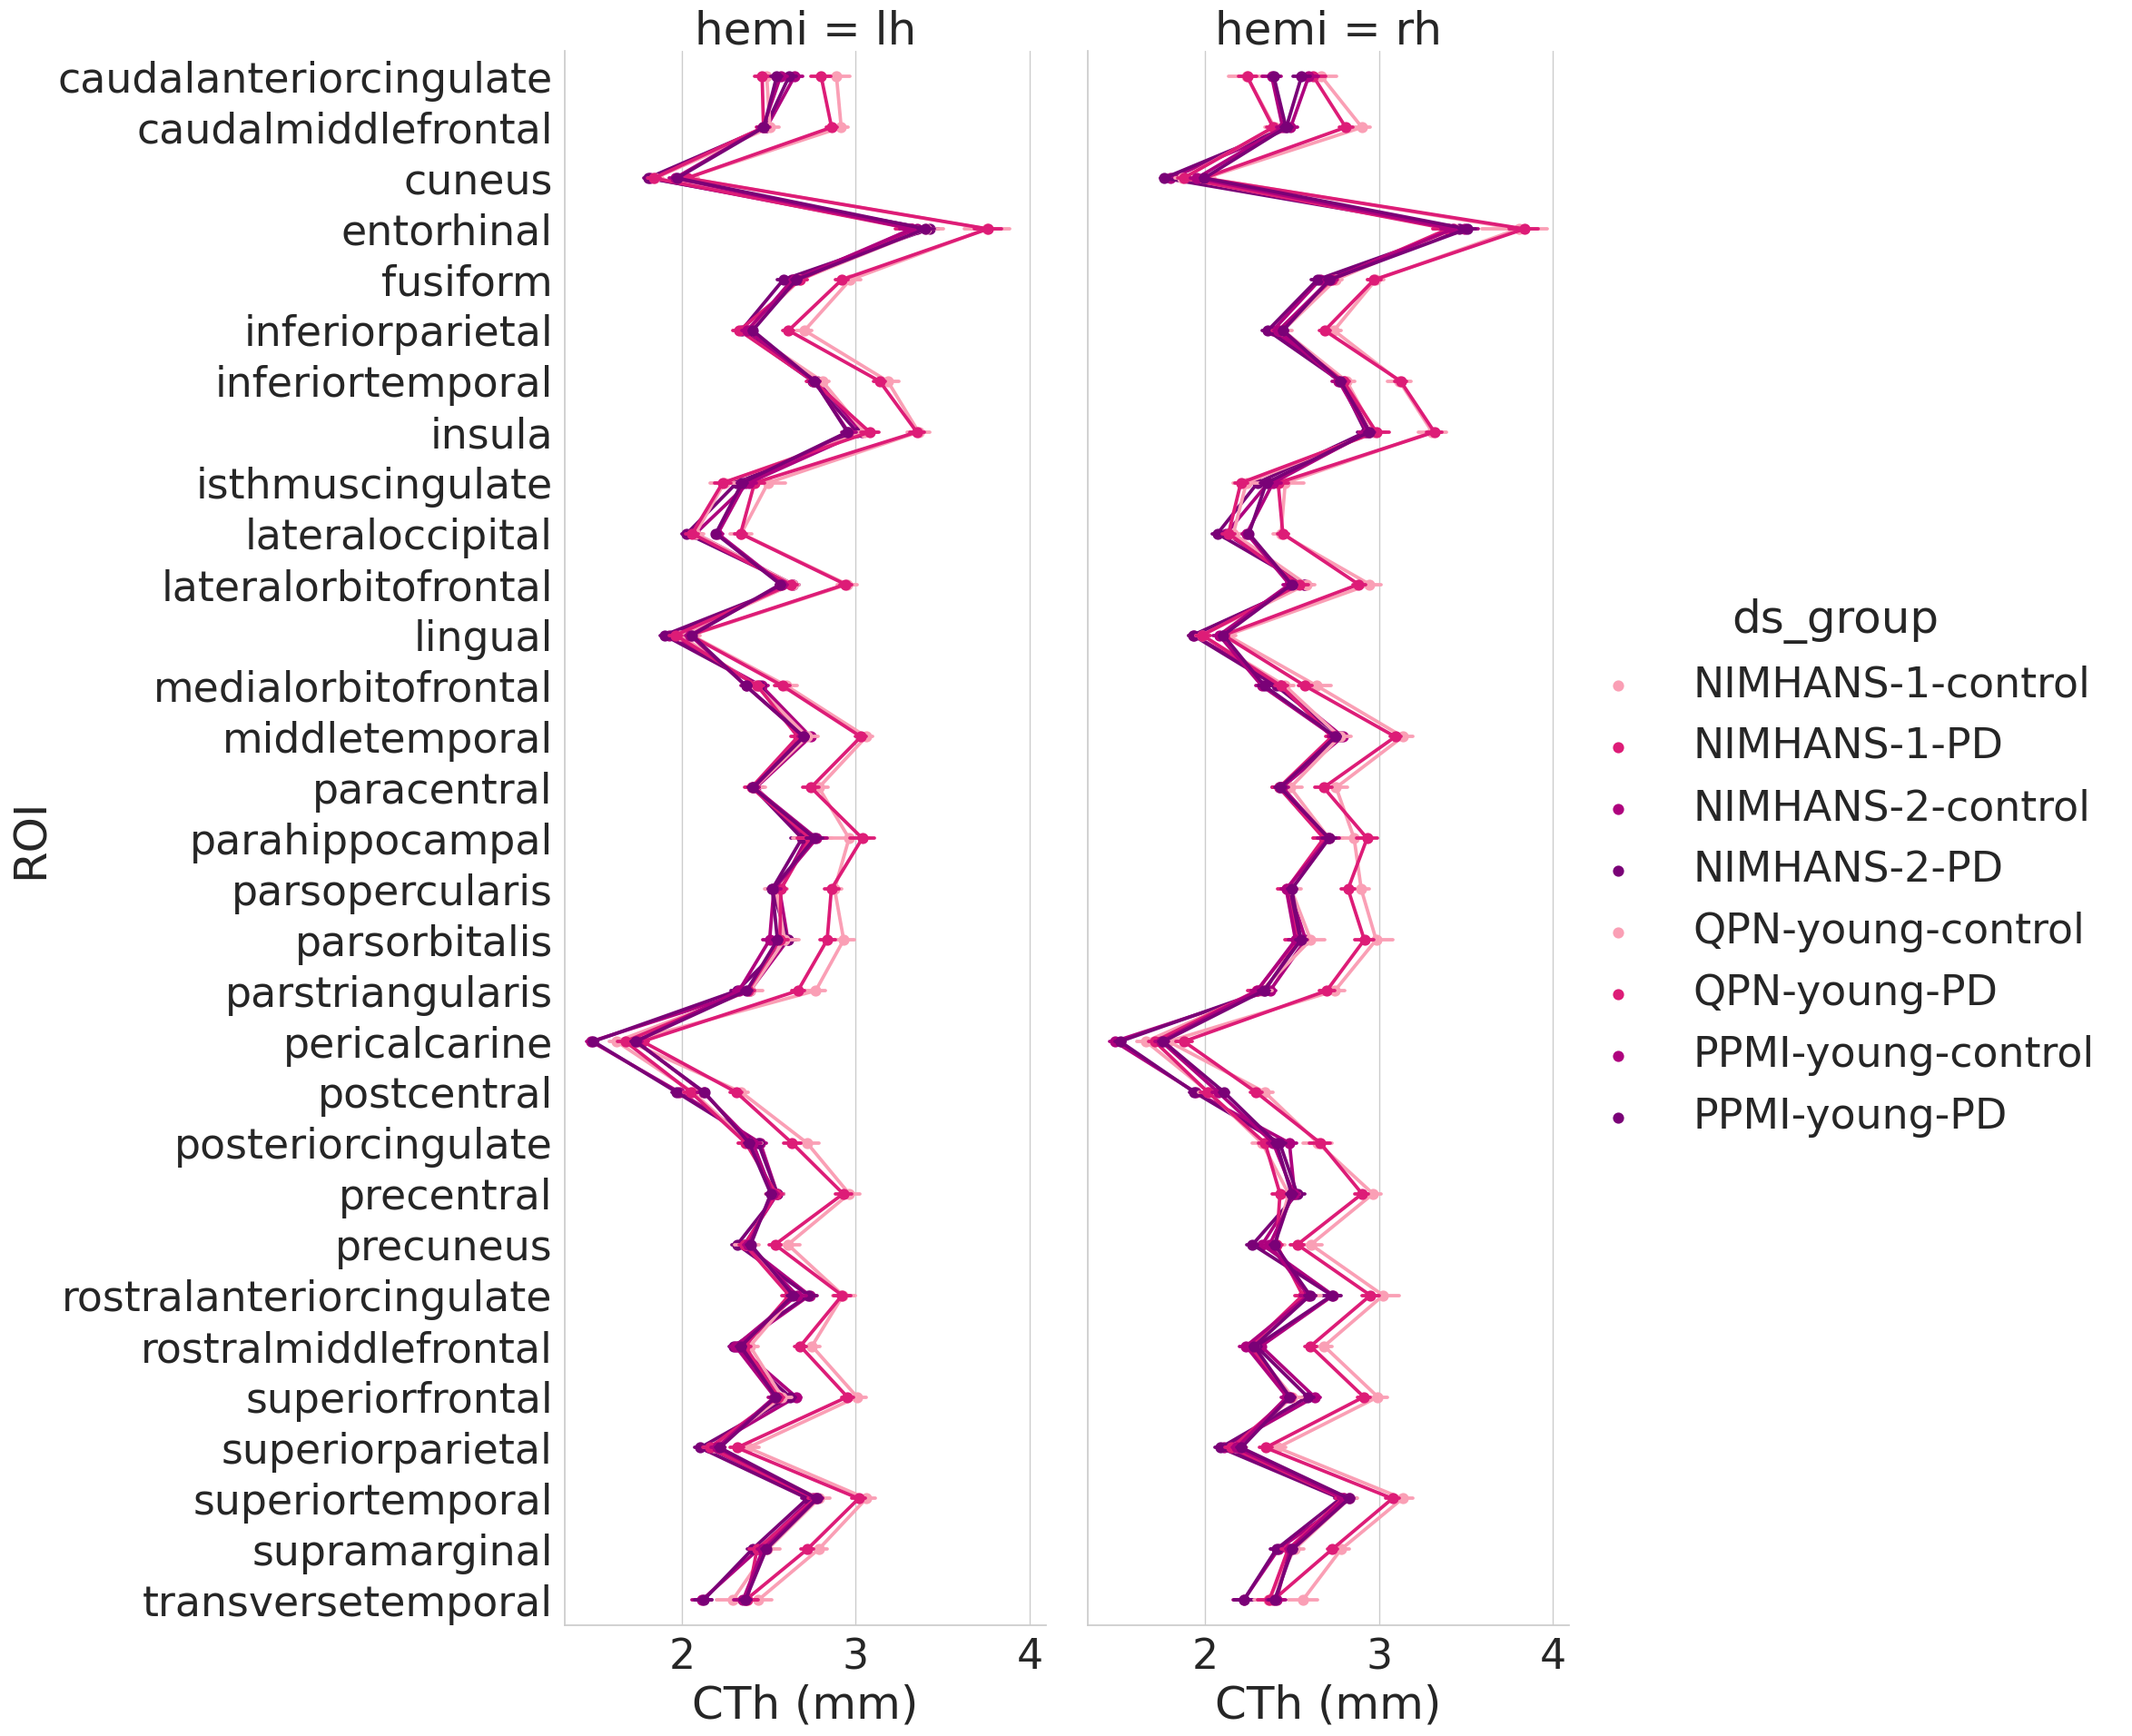

In [24]:
save_fig = False

# CT_DKT_df = CT_DKT_df[CT_DKT_df["dataset"].isin(["PPMI", "QPN", "NIMHANS_SERB"])]
CT_DKT_df = CT_DKT_df[CT_DKT_df["group"].isin(["control", "PD"])]

hue_order = ["NIMHANS-1-control", "NIMHANS-1-PD", "NIMHANS-2-control", "NIMHANS-2-PD", 
             "QPN-young-control", "QPN-young-PD", 
             "PPMI-young-control",  "PPMI-young-PD"]

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["ds_group","ds_hemi"],
    var_name="ROI", 
    value_name="CTh (mm)")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

sns.set_theme(font_scale=3)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CTh (mm)", hue="ds_group", col="hemi",kind="point",palette=palette, hue_order=hue_order, legend=True,
                    data=plot_df, aspect=0.5, height=20)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT.png")

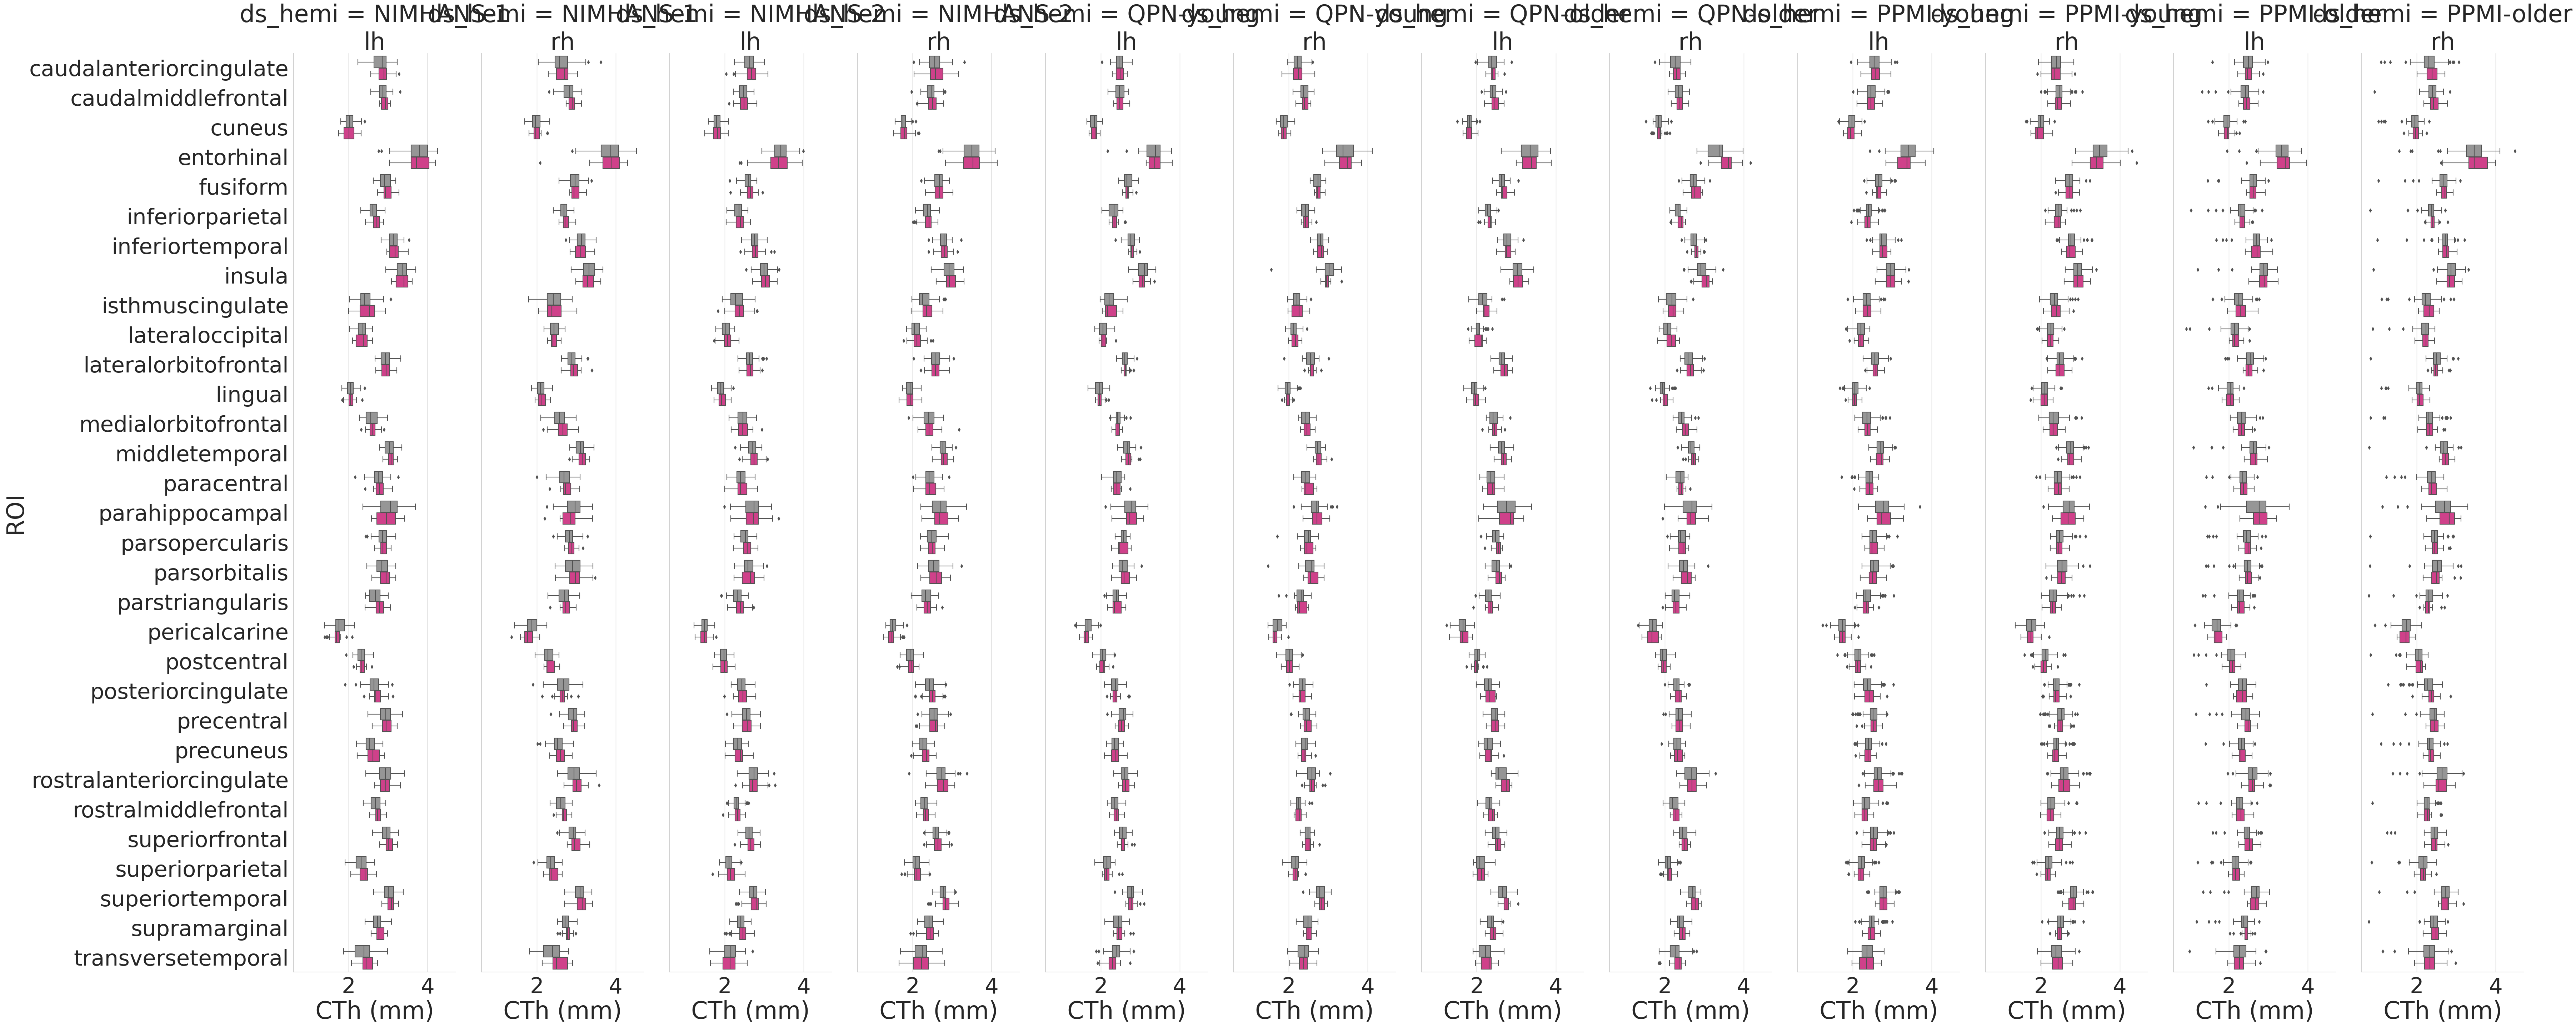

In [38]:
save_fig = True

# CT_DKT_df = CT_DKT_df[CT_DKT_df["dataset"].isin(["PPMI", "QPN", "NIMHANS_SERB"])]
CT_DKT_df = CT_DKT_df[CT_DKT_df["group"].isin(["control", "PD"])]

color_list = [  "#969696", "#e7298a" ]

palette_group = sns.color_palette(palette=color_list)

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["ds_group","ds_hemi"],
    var_name="ROI", 
    value_name="CTh (mm)")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

sns.set_theme(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CTh (mm)", hue="group", col="ds_hemi", kind="box",palette=palette_group, legend=False,
                    data=plot_df, aspect=0.2, height=30)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT.png")

### Aseg bilateral volume

In [34]:
# NIMHANS (SERB + METAL)
nimhans_serb_hemi_ASEG_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_hemi_ASEG_df["ds"] = "NIMHANS-1"
n_nimhans_serb_participants = len(nimhans_serb_hemi_ASEG_df["participant_id"].unique())

nimhans_metal_hemi_ASEG_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_metal_hemi_ASEG_df["ds"] = "NIMHANS-2"
n_nimhans_metal_participants = len(nimhans_metal_hemi_ASEG_df["participant_id"].unique())

# QPN
qpn_hemi_ASEG_df = pd.read_csv(f"{qpn_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
qpn_hemi_ASEG_df["ds"] = "QPN"
n_qpn_participants = len(qpn_hemi_ASEG_df["participant_id"].unique())

# PPMI
ppmi_hemi_ASEG_df = pd.read_csv(f"{ppmi_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
ppmi_hemi_ASEG_df["ds"] = "PPMI"
n_ppmi_participants = len(ppmi_hemi_ASEG_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants,n_nimhans_metal_participants)}, n_qpn_participants:{n_qpn_participants}")

if match_age:
    print(f"Matching age < {age_thresh}")

    ppmi_younger_hemi_ASEG_df = ppmi_hemi_ASEG_df[ppmi_hemi_ASEG_df["age"] < age_thresh].copy()
    ppmi_younger_hemi_ASEG_df["ds"] = "PPMI-young"
    n_younger_ppmi_participants = len(ppmi_younger_hemi_ASEG_df["participant_id"].unique())

    ppmi_older_hemi_ASEG_df = ppmi_hemi_ASEG_df[ppmi_hemi_ASEG_df["age"] >= age_thresh].copy()
    ppmi_older_hemi_ASEG_df["ds"] = "PPMI-older"
    n_older_ppmi_participants = len(ppmi_older_hemi_ASEG_df["participant_id"].unique())

    qpn_younger_hemi_ASEG_df = qpn_hemi_ASEG_df[qpn_hemi_ASEG_df["age"] < age_thresh].copy()
    qpn_younger_hemi_ASEG_df["ds"] = "QPN-young"
    n_qpn_younger_participants = len(qpn_younger_hemi_ASEG_df["participant_id"].unique())

    qpn_older_hemi_ASEG_df = qpn_hemi_ASEG_df[qpn_hemi_ASEG_df["age"] >= age_thresh].copy()
    qpn_older_hemi_ASEG_df["ds"] = "QPN-older"
    n_qpn_older_participants = len(qpn_older_hemi_ASEG_df["participant_id"].unique())

    print(f"n_nimhans_participants: {(n_nimhans_serb_participants,n_nimhans_metal_participants)}")
    print(f"n_qpn_younger_participants:{n_qpn_younger_participants}, n_qpn_older_participants: {n_qpn_older_participants}")
    print(f"n_ppmi_younger_participants:{n_younger_ppmi_participants}, n_ppmi_older_participants: {n_older_ppmi_participants}")

# Concat
hemi_ASEG_df = pd.concat([nimhans_serb_hemi_ASEG_df, nimhans_metal_hemi_ASEG_df, 
                          qpn_younger_hemi_ASEG_df, qpn_older_hemi_ASEG_df,
                          ppmi_younger_hemi_ASEG_df, ppmi_older_hemi_ASEG_df], axis=0)
hemi_ASEG_df["ds_group"] = hemi_ASEG_df["ds"] + "-" + hemi_ASEG_df["group"]
hemi_ASEG_df["ds_hemi"] = hemi_ASEG_df["ds"] + "\n" + hemi_ASEG_df["hemi"]
print(f"hemi_ASEG_df shape: {hemi_ASEG_df.shape}")

# Add BIDS_ID for PPMI

## tmp
# hemi_ASEG_df = hemi_ASEG_df.drop(columns=["participant_id"])

hemi_ASEG_df.head()

n_nimhans_participants: (86, 130), n_qpn_participants:287
Matching age < 65
n_nimhans_participants: (86, 130)
n_qpn_younger_participants:57, n_qpn_older_participants: 73
n_ppmi_younger_participants:237, n_ppmi_older_participants: 168
hemi_ASEG_df shape: (1502, 25)


,Cerebellum-White-Matter,Amygdala,Lateral-Ventricle,Cerebellum-Cortex,Putamen,Thalamus-Proper,vessel,choroid-plexus,Caudate,Hippocampus,...,bids_id,age,sex,group,hemi,ds,CerebralWhiteMatter,Cortex,ds_group,ds_hemi
0,14102.900391,1659.300049,9170.500000,49608.800781,4586.500000,6357.399902,125.800003,684.400024,3355.899902,3580.399902,...,sub-SERB088,54.0,M,PD,lh,NIMHANS-1,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh
1,12641.299805,1223.000000,7667.399902,42569.199219,3512.899902,5716.799805,24.000000,623.900024,2633.600098,3400.500000,...,sub-SERB058,64.0,M,PD,lh,NIMHANS-1,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh
2,20009.800781,1357.099976,16945.599609,50561.199219,4779.700195,6195.899902,29.299999,1066.400024,3021.699951,3541.500000,...,sub-SERB049,62.0,M,PD,lh,NIMHANS-1,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh
3,10348.900391,1344.599976,10064.700195,41859.898438,2910.699951,5412.100098,13.900000,818.299988,1672.599976,3827.000000,...,sub-SERB084,NaN,NaN,PD,lh,NIMHANS-1,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh
4,11251.599609,1442.900024,8531.599609,46157.500000,3410.100098,5824.899902,40.000000,592.799988,2352.199951,3377.800049,...,sub-SERB063,56.0,M,PD,lh,NIMHANS-1,NaN,NaN,NIMHANS-1-PD,NIMHANS-1\nlh


In [33]:
plot_df.head()

,bids_id,age,sex,group,hemi,ds,ds_group,ds_hemi,ROI,volume
0,sub-SERB088,54.0,M,PD,lh,NIMHANS-1,NIMHANS-1-PD,NIMHANS-1\nlh,Cerebellum-White-Matter,14102.900391
1,sub-SERB058,64.0,M,PD,lh,NIMHANS-1,NIMHANS-1-PD,NIMHANS-1\nlh,Cerebellum-White-Matter,12641.299805
2,sub-SERB049,62.0,M,PD,lh,NIMHANS-1,NIMHANS-1-PD,NIMHANS-1\nlh,Cerebellum-White-Matter,20009.800781
3,sub-SERB084,NaN,NaN,PD,lh,NIMHANS-1,NIMHANS-1-PD,NIMHANS-1\nlh,Cerebellum-White-Matter,10348.900391
4,sub-SERB063,56.0,M,PD,lh,NIMHANS-1,NIMHANS-1-PD,NIMHANS-1\nlh,Cerebellum-White-Matter,11251.599609


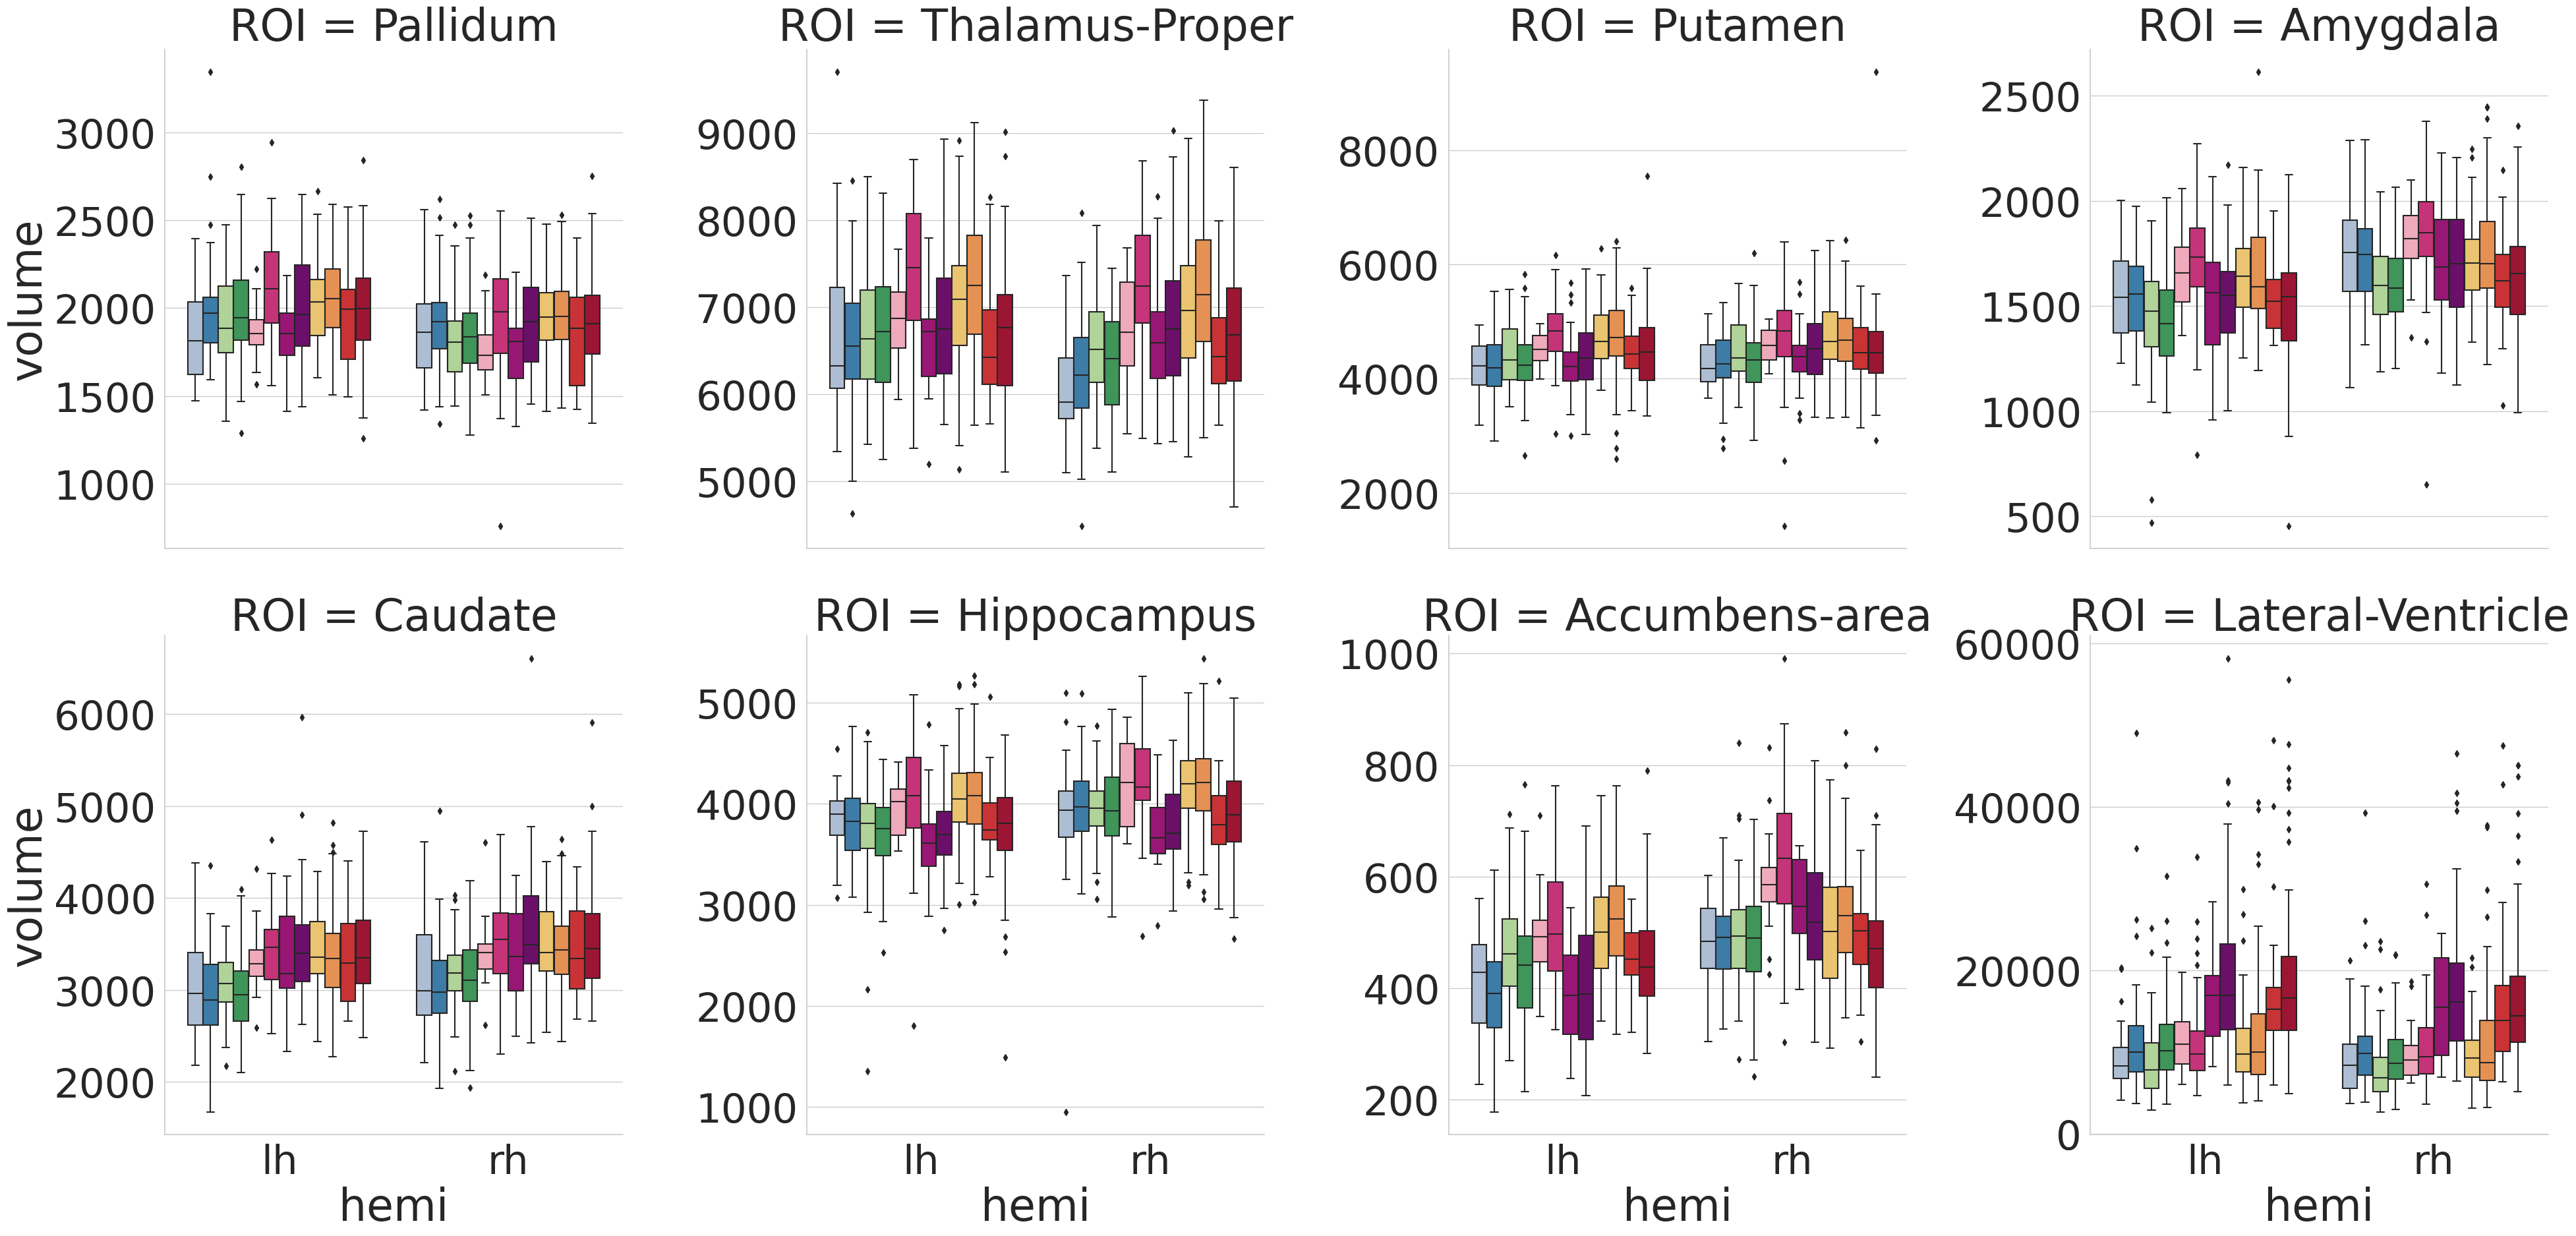

In [37]:
save_fig = True

# hemi_ASEG_df = hemi_ASEG_df[hemi_ASEG_df["dataset"].isin(["PPMI", "QPN", "NIMHANS_SERB"])]
hemi_ASEG_df = hemi_ASEG_df[hemi_ASEG_df["group"].isin(["control", "PD"])]

vol_ASEG_df_melt = hemi_ASEG_df.melt(
    id_vars=demo_cols + ["ds_group","ds_hemi"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = vol_ASEG_df_melt.copy()
plot_df = plot_df.drop(columns=["participant_id"])

plot_df["ROI"] = plot_df["ROI"].astype(str)
hemi_roi_list = ['Pallidum', 'Thalamus-Proper', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'Accumbens-area', 
                 'Lateral-Ventricle']
#'Cerebellum-Cortex','Cerebellum-White-Matter','VentralDC','Inf-Lat-Vent'
hue_order = ["NIMHANS-1-control", "NIMHANS-1-PD", "NIMHANS-2-control", "NIMHANS-2-PD", 
             "QPN-young-control", "QPN-young-PD", "QPN-older-control", "QPN-older-PD",
             "PPMI-young-control",  "PPMI-young-PD","PPMI-older-control",  "PPMI-older-PD"] 

sns.set_theme(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="ds_group", col="ROI",kind="box", col_wrap=4, col_order=hemi_roi_list, hue_order=hue_order,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False, legend=False)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_hemi.png")

### Global volumes

In [55]:
# NIMHANS (SERB + METAL)
nimhans_serb_global_ASEG_df = pd.read_csv(f"{nimhans_serb_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_serb_global_ASEG_df["ds"] = "NIMHANS-1"
n_nimhans_serb_participants = len(nimhans_serb_global_ASEG_df["participant_id"].unique())

nimhans_metal_global_ASEG_df = pd.read_csv(f"{nimhans_metal_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_metal_global_ASEG_df["ds"] = "NIMHANS-2"
n_nimhans_metal_participants = len(nimhans_metal_global_ASEG_df["participant_id"].unique())

# QPN
qpn_global_ASEG_df = pd.read_csv(f"{qpn_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
qpn_global_ASEG_df["ds"] = "QPN"
n_qpn_participants = len(qpn_global_ASEG_df["participant_id"].unique())

# PPMI
ppmi_global_ASEG_df = pd.read_csv(f"{ppmi_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
ppmi_global_ASEG_df["ds"] = "PPMI"
n_ppmi_participants = len(ppmi_global_ASEG_df["participant_id"].unique())

print(f"n_nimhans_participants: {(n_nimhans_serb_participants, n_nimhans_metal_participants)}, n_qpn_participants:{n_qpn_participants}")


if match_age:
    print(f"Matching age < {age_thresh}")

    ppmi_younger_global_ASEG_df = ppmi_global_ASEG_df[ppmi_global_ASEG_df["age"] < age_thresh].copy()
    ppmi_younger_global_ASEG_df["ds"] = "PPMI-young"
    n_younger_ppmi_participants = len(ppmi_younger_global_ASEG_df["participant_id"].unique())

    ppmi_older_global_ASEG_df = ppmi_global_ASEG_df[ppmi_global_ASEG_df["age"] >= age_thresh].copy()
    ppmi_older_global_ASEG_df["ds"] = "PPMI-older"
    n_older_ppmi_participants = len(ppmi_older_global_ASEG_df["participant_id"].unique())

    qpn_younger_global_ASEG_df = qpn_global_ASEG_df[qpn_global_ASEG_df["age"] < age_thresh].copy()
    qpn_younger_global_ASEG_df["ds"] = "QPN-young"
    n_qpn_younger_participants = len(qpn_younger_global_ASEG_df["participant_id"].unique())

    qpn_older_global_ASEG_df = qpn_global_ASEG_df[qpn_global_ASEG_df["age"] >= age_thresh].copy()
    qpn_older_global_ASEG_df["ds"] = "QPN-older"
    n_qpn_older_participants = len(qpn_older_global_ASEG_df["participant_id"].unique())

    print(f"n_nimhans_participants: {(n_nimhans_serb_participants,n_nimhans_metal_participants)}")
    print(f"n_qpn_younger_participants:{n_qpn_younger_participants}, n_qpn_older_participants: {n_qpn_older_participants}")
    print(f"n_ppmi_younger_participants:{n_younger_ppmi_participants}, n_ppmi_older_participants: {n_older_ppmi_participants}")

# Concat
global_vol_ASEG_df = pd.concat([nimhans_serb_global_ASEG_df, nimhans_metal_global_ASEG_df, 
                          qpn_younger_global_ASEG_df, qpn_older_global_ASEG_df,
                          ppmi_younger_global_ASEG_df, ppmi_older_global_ASEG_df], axis=0)

global_vol_ASEG_df["ds_group"] = global_vol_ASEG_df["ds"] + "-" + global_vol_ASEG_df["group"]

print(f"global_vol_ASEG_df shape: {global_vol_ASEG_df.shape}")

## tmp
# qpn_global_ASEG_df = qpn_global_ASEG_df.drop(columns=["participant_id"])

qpn_global_ASEG_df.head()

n_nimhans_participants: (86, 130), n_qpn_participants:287
Matching age < 65
n_nimhans_participants: (86, 130)
n_qpn_younger_participants:57, n_qpn_older_participants: 73
n_ppmi_younger_participants:237, n_ppmi_older_participants: 168
global_vol_ASEG_df shape: (751, 32)


,3rd-Ventricle,4th-Ventricle,5th-Ventricle,Brain-Stem,BrainSeg,BrainSegNotVent,BrainSegNotVent.1,CC_Anterior,CC_Central,CC_Mid_Anterior,...,TotalGray,VentricleChoroidVol,WM-hypointensities,non-WM-hypointensities,participant_id,age,sex,group,hemi,ds
0,1360.3,1787.4,0.0,25180.7,1268014.0,1241132.0,1241132.0,1322.0,531.8,648.6,...,640926.078926,22462.0,840.9,0.0,MNI0028,NaN,M,PD,global,QPN
1,2976.9,2691.0,0.0,20471.7,1250678.0,1160664.0,1160664.0,1011.1,445.4,491.8,...,619693.412514,82652.0,6680.3,0.0,MNI0056,79.2,M,PD,global,QPN
2,1429.2,988.4,0.0,27453.5,1250635.0,1233803.0,1233803.0,768.3,756.6,578.4,...,647481.631716,13498.0,7384.4,0.0,MNI0058,57.4,M,PD,global,QPN
3,1348.8,1599.4,0.0,20654.2,1063409.0,1037897.0,1037897.0,854.4,420.8,705.6,...,581838.746237,21777.0,2428.0,0.0,MNI0068,69.3,M,PD,global,QPN
4,952.4,1449.5,0.0,21743.1,1144991.0,1131912.0,1131912.0,930.8,801.1,797.4,...,626431.995060,9824.0,656.9,0.0,MNI0079,50.1,F,PD,global,QPN


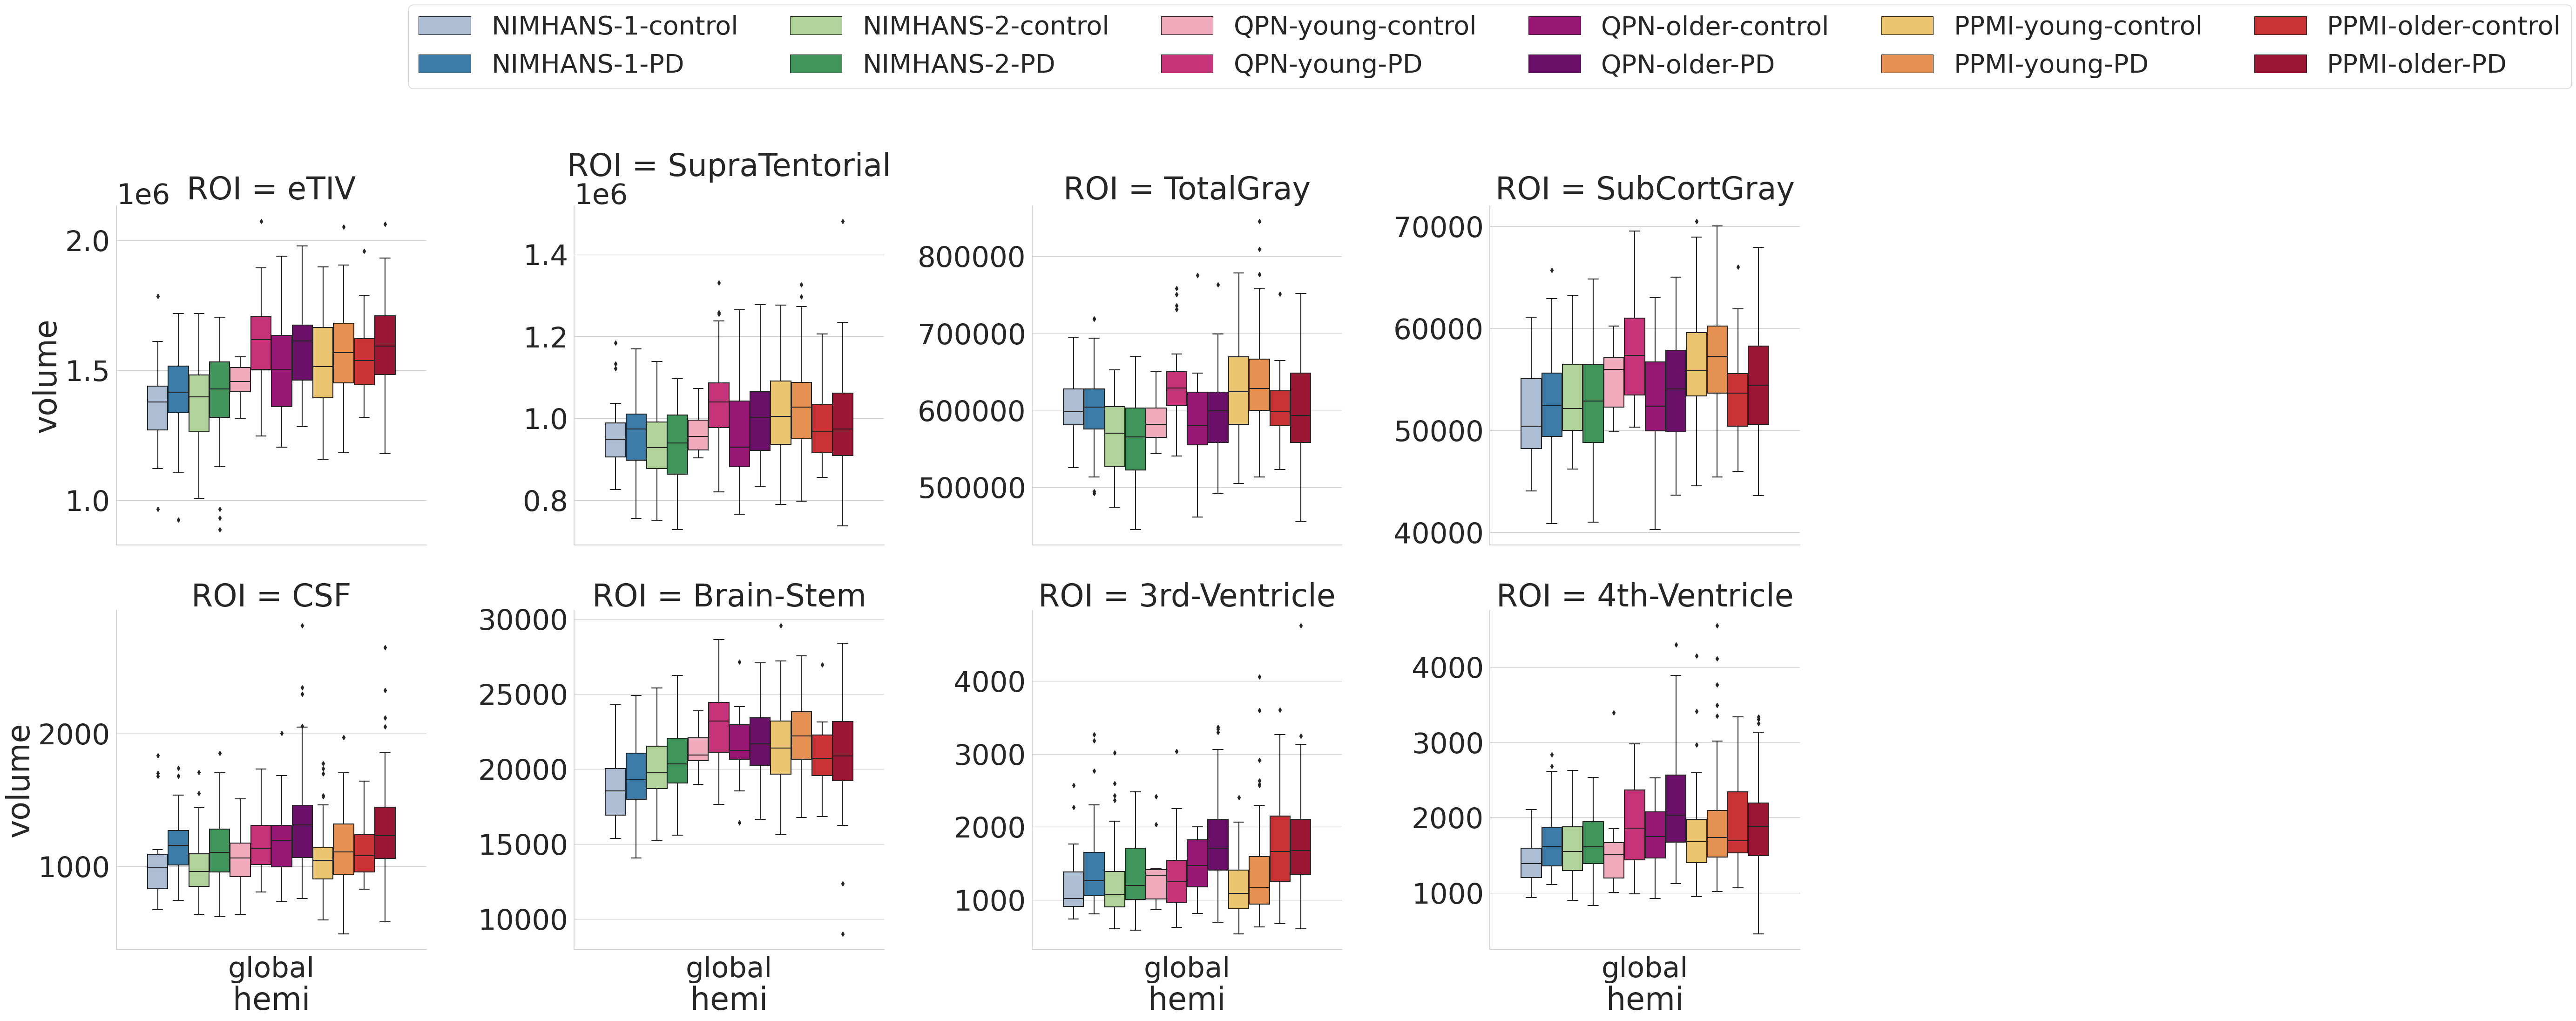

In [62]:
save_fig = True

# global_vol_ASEG_df = global_vol_ASEG_df[global_vol_ASEG_df["dataset"].isin(["PPMI", "QPN","NIMHANS_SERB"])]

global_vol_ASEG_df = global_vol_ASEG_df[global_vol_ASEG_df["group"].isin(["control", "PD"])]

global_vol_ASEG_df = global_vol_ASEG_df.rename(columns={"EstimatedTotalIntraCranial":"eTIV",
                                                        "EstimatedTotalIntraCranialVol":"eTIV"})

global_vol_ASEG_df_melt = global_vol_ASEG_df.melt(
    id_vars=demo_cols + ["ds_group"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = global_vol_ASEG_df_melt.copy()

global_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", 
                    "CSF","Brain-Stem","3rd-Ventricle","4th-Ventricle"]
plot_df = plot_df[plot_df["ROI"].isin(global_roi_list)]

hue_order = ["NIMHANS-1-control", "NIMHANS-1-PD", "NIMHANS-2-control", "NIMHANS-2-PD", 
             "QPN-young-control", "QPN-young-PD", "QPN-older-control", "QPN-older-PD",
             "PPMI-young-control",  "PPMI-young-PD","PPMI-older-control",  "PPMI-older-PD"] 

sns.set_theme(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="ds_group", col="ROI", kind="box", col_wrap=4, 
                    col_order=global_roi_list, hue_order=hue_order,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False, legend=False)
    
    # plt.legend(bbox_to_anchor =(0,2.5), loc='lower center',ncol=6, fontsize=40)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_global.png")

### Demographics

In [64]:
demo_df = global_vol_ASEG_df[demo_cols].copy()
demo_df.groupby(["ds","group"]).count()

participant_id  bids_id  age  sex  hemi
ds         group                                           
NIMHANS-1  PD                   64       64   54   55    64
           control              22       22   15   15    22
NIMHANS-2  PD                   66       66   59   59    66
           control              64       64   64   64    64
PPMI-older PD                  102        0  102  102   102
           control              29        0   29   29    29
PPMI-young PD                  127        0  127  127   127
           control              50        0   50   50    50
QPN-older  PD                   52        0   52   52    52
           control              21        0   21   21    21
QPN-young  PD                   41        0   41   41    41
           control              16        0   16   15    16

In [66]:
demo_df.groupby(["ds","group"])["age"].describe()

count       mean        std   min    25%    50%     75%  \
ds         group                                                              
NIMHANS-1  PD        54.0  55.388889   7.199100  36.0  50.25  56.00  61.000   
           control   15.0  52.000000   6.011893  41.0  49.00  53.00  56.500   
NIMHANS-2  PD        59.0  53.644068  10.133187  24.0  46.00  55.00  61.000   
           control   64.0  50.015625  10.418988  20.0  42.75  50.00  57.250   
PPMI-older PD       102.0  70.843137   3.949546  65.0  68.00  70.00  73.000   
           control   29.0  70.413793   4.762332  65.0  66.00  70.00  73.000   
PPMI-young PD       127.0  55.826772   6.237488  38.0  51.50  56.00  61.000   
           control   50.0  53.580000   8.535855  31.0  49.00  55.50  60.000   
QPN-older  PD        52.0  72.123077   5.461689  65.0  68.00  71.30  75.925   
           control   21.0  71.361905   4.421140  65.1  68.20  70.90  73.100   
QPN-young  PD        41.0  56.624390   5.999199  40.8  53.00  57.60  61.100   
           control   16.0  55.837500   7.046784  43.4  49.15  57.85  61.725   

                     max  
ds         group          
NIMHANS-1  PD       67.0  
           control  60.0  
NIMHANS-2  PD       72.0  
           control  73.0  
PPMI-older PD       82.0  
           control  81.0  
PPMI-young PD       64.0  
           control  64.0  
QPN-older  PD       88.3  
           control  80.4  
QPN-young  PD       64.6  
           control  63.5

### OLS

In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [24]:
stat_df = global_vol_ASEG_df.copy()
dataset_list = ["NIMHANS_SERB","NIMHANS_METAL"]
hemi = "global"
stat_df = stat_df[(stat_df["dataset"].isin(dataset_list)) & (stat_df["hemi"]==hemi)]

brain_var = "eTIV"
demo_vars = ["participant_id","age","sex","group","hemi","dataset"]

input_var = demo_vars + [brain_var]

stat_df = stat_df[input_var]
stat_df.head()

,participant_id,age,sex,group,hemi,dataset,eTIV
0,SERB088,54.0,M,PD,global,NIMHANS_SERB,1.426910e+06
1,SERB058,64.0,M,PD,global,NIMHANS_SERB,1.296458e+06
2,SERB049,62.0,M,PD,global,NIMHANS_SERB,1.566405e+06
3,SERB084,NaN,NaN,PD,global,NIMHANS_SERB,1.213594e+06
4,SERB063,56.0,M,PD,global,NIMHANS_SERB,1.264406e+06


In [25]:
def get_stats(stat_df, ind_var, dep_var, cat_vars, global_correction=False):
    cvar_str = ""
    for cvar in cat_vars:
        cvar_str = "".join([f"{cvar_str} + C({cvar})"])    

    if global_correction:
        formula = f"{ind_var} ~ {dep_var}{cvar_str} + {global_correction}"
    else:
        formula = f"{ind_var} ~ {dep_var}{cvar_str}"
        
    res = smf.ols(formula=formula, data=stat_df).fit()
    
    tval_df = pd.DataFrame(columns=["tvalues"], data=res.tvalues)
    pval_df = pd.DataFrame(columns=["pvalues"], data=res.pvalues)
    res_df = pd.concat([tval_df, pval_df], axis=1)
    res_df = res_df.reset_index().rename(columns={"index":"var"})

    return res_df, res, formula

### Replication analysis
- Group differences within each dataset

In [32]:
dep_var = "age"
cat_vars = ["sex", "group"]
dataset_list = ["NIMHANS_SERB","NIMHANS_METAL","QPN","PPMI"]

pval_thresh = 0.05

### Global volumes

In [33]:
brain_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", "CSF"]
hemi = "global"
res_df = pd.DataFrame()
for ds in dataset_list:
    for ind_var in brain_roi_list:
        # print(f"ds:{ds}, ind_var:{ind_var}")
        stat_df = global_vol_ASEG_df.copy()
        stat_df = stat_df[(stat_df["dataset"]==ds) & (stat_df["hemi"]==hemi)]
        _df, res, formula = get_stats(stat_df, ind_var, dep_var, cat_vars, global_correction)
        _df["ROI"] = ind_var
        _df["hemi"] = hemi
        _df["dataset"] = ds
        res_df = pd.concat([res_df, _df], axis=0)


res_df[(res_df["var"]=="C(group)[T.control]") & (res_df["pvalues"] < pval_thresh)]

,var,tvalues,pvalues,ROI,hemi,dataset
2,C(group)[T.control],-3.014494,0.003152,CSF,global,NIMHANS_METAL
2,C(group)[T.control],2.529654,0.013488,eTIV,global,QPN


### Subcortical volumes

In [34]:
brain_roi_list = ['Pallidum', 'ThalamusProper', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'AccumbensArea']
hemi_list = ["lh", "rh"]
global_correction = "eTIV"
# rename columns with "-" to remove error in statsmodels
hemi_ASEG_df = hemi_ASEG_df.rename(columns={"Thalamus-Proper":"ThalamusProper", 'Accumbens-area':'AccumbensArea'})

res_df = pd.DataFrame()
for ds in dataset_list:
    for ind_var in brain_roi_list:
        for hemi in hemi_list:
            # print(f"ds:{ds}, ind_var:{ind_var}")
            stat_df = hemi_ASEG_df.copy()
            stat_df = stat_df[(stat_df["dataset"]==ds) & (stat_df["hemi"]==hemi)]

            if global_correction:
                stat_df = pd.merge(stat_df, global_vol_ASEG_df[["participant_id","eTIV"]], on="participant_id", how="left")
                _df, _, formula = get_stats(stat_df, ind_var, dep_var, cat_vars, global_correction)
            else:
                _df, _, formula = get_stats(stat_df, ind_var, dep_var, cat_vars)

            _df["ROI"] = ind_var
            _df["hemi"] = hemi
            _df["dataset"] = ds
            res_df = pd.concat([res_df, _df], axis=0)


res_df[(res_df["var"]=="C(group)[T.control]") & (res_df["pvalues"] < pval_thresh)]

,var,tvalues,pvalues,ROI,hemi,dataset
2,C(group)[T.control],2.389288,0.018466,ThalamusProper,rh,NIMHANS_METAL
2,C(group)[T.control],2.352978,0.020279,Putamen,rh,NIMHANS_METAL
2,C(group)[T.control],2.596371,0.010619,Caudate,lh,NIMHANS_METAL
2,C(group)[T.control],2.117504,0.036316,AccumbensArea,lh,NIMHANS_METAL
2,C(group)[T.control],-2.180160,0.032341,AccumbensArea,rh,QPN
2,C(group)[T.control],-2.175419,0.031254,ThalamusProper,lh,PPMI
2,C(group)[T.control],-1.981722,0.049441,ThalamusProper,rh,PPMI


### CTh

In [35]:
brain_roi_list = CT_DKT_df[CT_DKT_df.columns[~CT_DKT_df.columns.isin(demo_cols + ["ds_group"])]].columns
print(f"n_brain_rois: {len(brain_roi_list)}")
hemi_list = ["lh", "rh"]

res_df = pd.DataFrame()
for ds in dataset_list:
    for ind_var in brain_roi_list:
        for hemi in hemi_list:
            # print(f"ds:{ds}, ind_var:{ind_var}")
            stat_df = CT_DKT_df.copy()
            stat_df = stat_df[(stat_df["dataset"]==ds) & (stat_df["hemi"]==hemi)]
            _df, _, formula = get_stats(stat_df, ind_var, dep_var, cat_vars)
            _df["ROI"] = ind_var
            _df["hemi"] = hemi
            _df["dataset"] = ds
            res_df = pd.concat([res_df, _df], axis=0)


res_df[(res_df["var"]=="C(group)[T.control]") & (res_df["pvalues"] < pval_thresh)]

n_brain_rois: 31


,var,tvalues,pvalues,ROI,hemi,dataset
2,C(group)[T.control],-2.094447,0.040123,posteriorcingulate,rh,NIMHANS_SERB
2,C(group)[T.control],2.717475,0.007561,parstriangularis,lh,NIMHANS_METAL
2,C(group)[T.control],-3.161196,0.002247,posteriorcingulate,rh,QPN


### Cross-cohort comparisons

In [21]:
brain_roi_list = ["eTIV", "SupraTentorial", "TotalGray", "SubCortGray", "CSF"]
dep_var = "age"
cat_vars = ["sex", "ds_group"]
pval_thresh = 0.05

group_list = ["control","PD"]
hemi = "global"
res_df = pd.DataFrame()
for grp in group_list:
    for ind_var in brain_roi_list:
        # print(f"ds:{ds}, ind_var:{ind_var}")
        stat_df = global_vol_ASEG_df.copy()
        stat_df = stat_df[(stat_df["group"]==grp) & (stat_df["hemi"]==hemi)]
        _df = get_stats(stat_df, ind_var, dep_var, cat_vars)
        _df["ROI"] = ind_var
        _df["hemi"] = hemi
        _df["group"] = grp
        res_df = pd.concat([res_df, _df], axis=0)


res_df[(~res_df["var"].isin(["Intercept","C(sex)[T.M]","age"])) & (res_df["pvalues"] < pval_thresh)]

TypeError: 'tuple' object does not support item assignment